In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load data
try:
    # Try loading the processed version first
    df = pd.read_csv('../data/processed/amazon_processed.csv')
    print("Loaded processed data")
except FileNotFoundError:
    # Fall back to raw data
    df = pd.read_csv('../data/amazon.csv')
    print("Loaded raw data")

# Display the first few rows
df.head()

# Check data types and missing values
print("Data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

# Data preprocessing
# Convert date column to datetime if it's not already
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    # Sort by date
    df = df.sort_values('date')
    # Set date as index
    df.set_index('date', inplace=True)
elif df.index.name == 'date':
    # If date is already the index, ensure it's datetime
    df.index = pd.to_datetime(df.index)

Loaded processed data
Data types:
date                           object
product_id                     object
product_name                   object
category                       object
discounted_price              float64
actual_price                  float64
discount_percentage           float64
rating                        float64
rating_count                  float64
about_product                  object
user_id                        object
user_name                      object
review_id                      object
review_title                   object
review_content                 object
img_link                       object
product_link                   object
daily_sales                   float64
year                            int64
month                           int64
day                             int64
dayofweek                       int64
quarter                         int64
is_weekend                       bool
is_month_start                   bool
is_month_end    

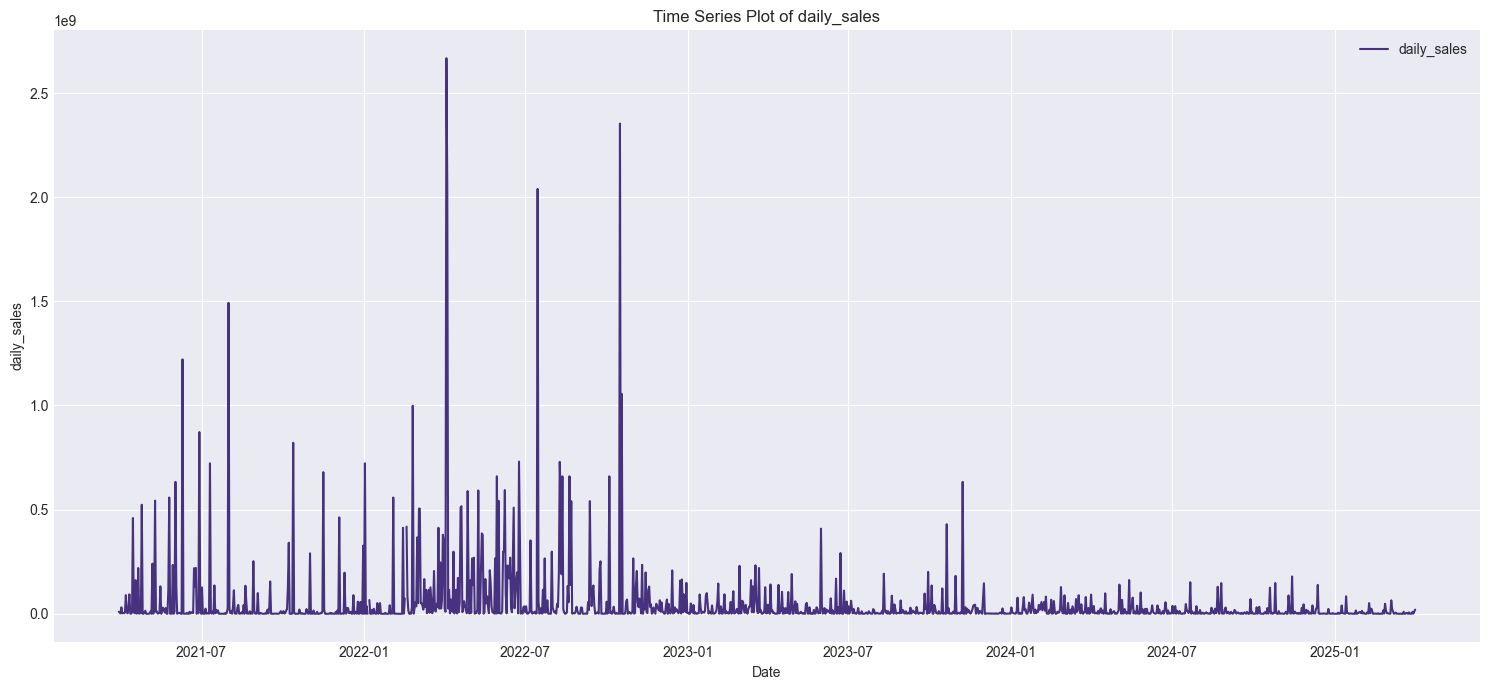

Error in seasonal decomposition: This function does not handle missing values


In [3]:
# Visualize the time series
plt.figure(figsize=(15, 7))

# Select target column (assuming 'daily_sales' is the target)
target_column = 'daily_sales' if 'daily_sales' in df.columns else df.columns[0]

plt.plot(df.index, df[target_column], label=target_column)
plt.title(f'Time Series Plot of {target_column}')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check for seasonal patterns
def seasonal_decompose_plot(series, period):
    """Decompose and plot seasonal components"""
    decomposition = sm.tsa.seasonal_decompose(series, period=period)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    return decomposition

# Choose a period for seasonal decomposition (e.g., 7 for weekly, 30 for monthly)
try:
    # Weekly seasonality
    decomposition = seasonal_decompose_plot(df[target_column], period=7)
except Exception as e:
    print(f"Error in seasonal decomposition: {e}")

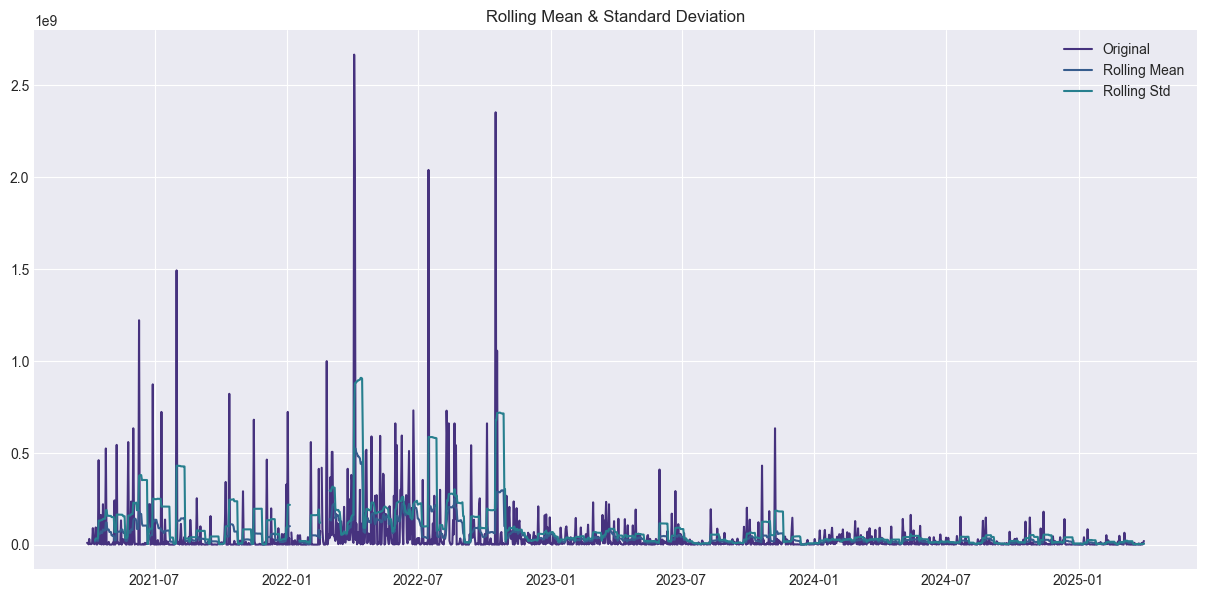

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -4.620834
p-value                           0.000118
#Lags Used                       24.000000
Number of Observations Used    1438.000000
Critical Value (1%)              -3.434906
Critical Value (5%)              -2.863552
Critical Value (10%)             -2.567841
dtype: float64

The time series is stationary (reject null hypothesis)


In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    """Check stationarity using ADF test and rolling statistics"""
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(timeseries, label='Original')
    ax.plot(rolling_mean, label='Rolling Mean')
    ax.plot(rolling_std, label='Rolling Std')
    ax.set_title('Rolling Mean & Standard Deviation')
    ax.legend()
    plt.show()
    
    # Perform ADF test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries.dropna())
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value
    print(adf_output)
    
    # Interpret results
    if adf_test[1] <= 0.05:
        print("\nThe time series is stationary (reject null hypothesis)")
    else:
        print("\nThe time series is non-stationary (fail to reject null hypothesis)")

# Check stationarity
check_stationarity(df[target_column])

Training set: 1172 observations
Testing set: 293 observations


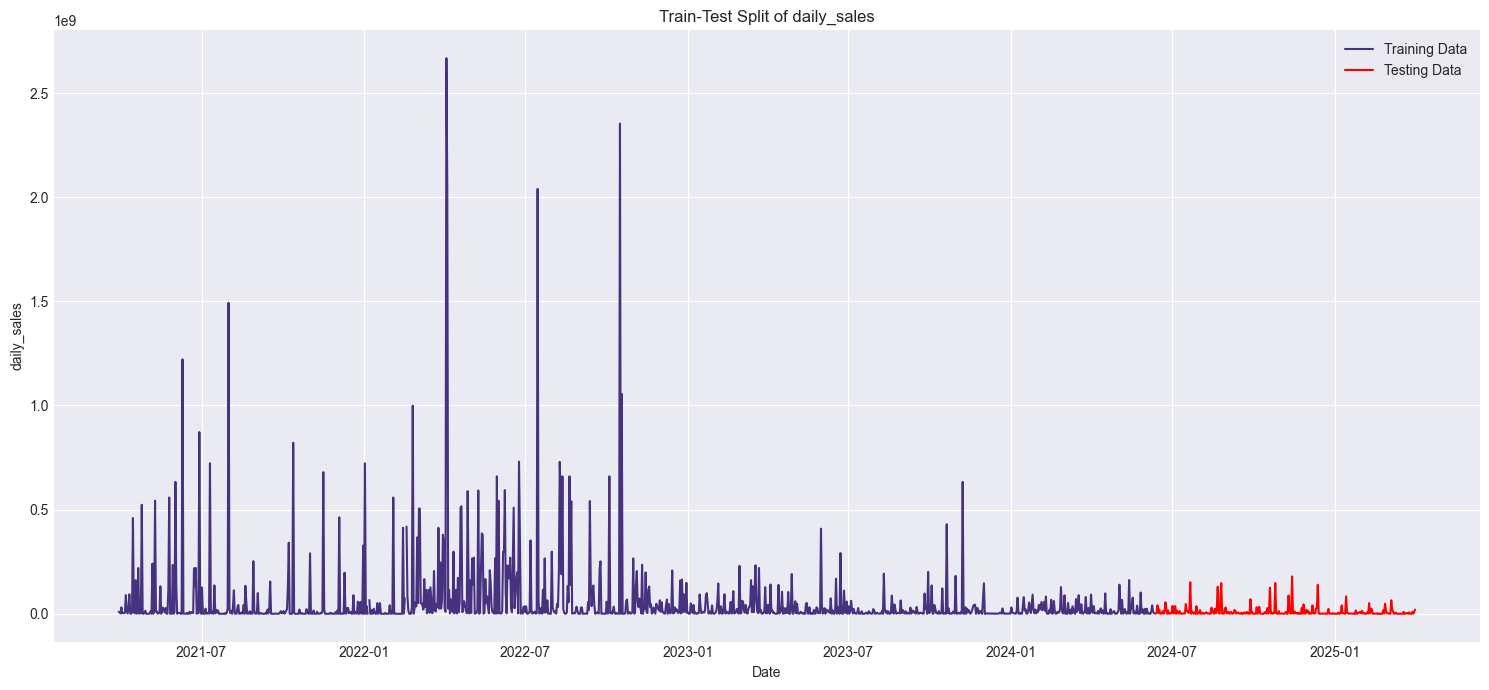

In [5]:
# Define the train-test split function
def train_test_split_ts(df, target_column, test_size=0.2):
    """Split time series data into train and test sets"""
    # Calculate the split point
    split_idx = int(len(df) * (1 - test_size))
    
    # Split the data
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    
    return train, test

# Split the data
train, test = train_test_split_ts(df, target_column, test_size=0.2)

print(f"Training set: {train.shape[0]} observations")
print(f"Testing set: {test.shape[0]} observations")

# Plot the train-test split
plt.figure(figsize=(15, 7))
plt.plot(train.index, train[target_column], label='Training Data')
plt.plot(test.index, test[target_column], label='Testing Data', color='red')
plt.title(f'Train-Test Split of {target_column}')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.tight_layout()
plt.show()